In [4]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import utils
import multiprocessing
device = torch.device("cuda:0")
num_cores = multiprocessing.cpu_count()

In [5]:
def add_noise(net):
    rate = 10
    weight = 0.01
    # Add Poisson drives
    weights_ampa_d1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight}
    rates_d1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate}

    net.add_poisson_drive(
        name='distal', tstart=0, tstop=None, rate_constant=rates_d1, location='distal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_d1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=1.0, event_seed=1, conn_seed=2)

    weights_ampa_p1 = {'L2_pyramidal': weight, 'L5_pyramidal': weight,
                       'L2_basket': weight, 'L5_basket': weight}
    rates_p1 = {'L2_pyramidal': rate, 'L5_pyramidal': rate, 'L2_basket': rate, 'L5_basket': rate}

    net.add_poisson_drive(
        name='proximal', tstart=0, tstop=None, rate_constant=rates_p1, location='proximal', n_drive_cells='n_cells',
        cell_specific=True, weights_ampa=weights_ampa_p1, weights_nmda=None, space_constant=1e50,
        synaptic_delays=0.0, probability=1.0, event_seed=3, conn_seed=4)

In [9]:
%%capture
hnn_core_root = op.dirname(hnn_core.__file__)
params_fname = op.join(hnn_core_root, 'param', 'default.json')
params = read_params(params_fname)
params.update({'N_pyr_x': 3, 'N_pyr_y': 3})
net = calcium_model(params)
add_noise(net)

dt = 0.5
dpl = simulate_dipole(net, dt=dt, tstop=1000, record_vsec='all', record_isec='all')

In [10]:
net_build = NetworkBuilder(net)

Building the NEURON model
[Done]


In [28]:
class SingleNeuron_Data:
    #'Characterizes a dataset for PyTorch'
    def __init__(self, net, gid):
        self.gid = gid
        self.cell_type = net.gid_to_type(self.gid)

        if self.cell_type in net.cell_types:
            self.is_cell = True

            # Get voltages
            vsec_list, vsec_names = list(), list()
            for sec_name, vsec in net.cell_response.vsec[0][gid].items():
                vsec_list.append(vsec)
                vsec_names.append(sec_name)
            self.vsec_names = vsec_names
            self.vsec_array = np.array(vsec_list)

            isec_list, isec_names = list(), list()
            # Get currents
            for sec_name, isec_dict in net.cell_response.isec[0][gid].items():
                for isec_name, isec in isec_dict.items():
                    isec_list.append(isec)
                    isec_names.append(isec_name)

            self.isec_array = np.array(isec_list)

            # Create dictionary to look up row for each section/receptor combo
            isec_name_lookup = {name: idx for idx, name in enumerate(isec_names)}
            self.isec_name_lookup = isec_name_lookup
            

        else:
            self.is_cell = False
            
            
        self.spikes_binned = self.get_binned_spikes(net)

    def get_binned_spikes(self, net):
        spike_times = np.array(net.cell_response.spike_times)
        spike_gids = np.array(net.cell_response.spike_gids)

        spike_times_gid = spike_times[spike_gids == self.gid]
        spikes_binned = np.histogram(spike_times_gid, bins=net.cell_response.times)[0]

        spikes_binned = np.concatenate([spikes_binned, [0.0]])
        return spikes_binned
        




In [38]:
class Network_Dataset:
    def __init__(self, net):
        self.net = net
        self.neuron_data_dict = dict()
        self.input_spike_dict = dict()
        
        for cell_type, gid_list in net.gid_ranges.items():
            for gid in gid_list:
                self.neuron_data_dict[gid] = SingleNeuron_Data(net, gid)

                # Initialize blank arrays for spikes recieved by each cell
                if cell_type in net.cell_types:
                    self.input_spike_dict[gid] = np.zeros(self.neuron_data_dict[gid].isec_array.shape)

        for conn in net.connectivity:
            for src_gid, target_gid_list in conn['gid_pairs'].items():

                # Loop through all target gids and append spikes to appropriate array
                # **TODO** - need to add weight and delay
                for target_gid in target_gid_list:
                    conn_spikes = self.neuron_data_dict[src_gid].spikes_binned

                    target_type = conn['target_type']
                    receptor = conn['receptor']
                    loc = conn['loc']

                    if loc in net.cell_types[target_type].sect_loc:
                        sect_loc = net.cell_types[target_type].sect_loc[loc]
                    else:
                        sect_loc = [loc]
                        assert loc in net.cell_types[target_type].sections

                    for sec in sect_loc:
                        input_spike_name = f'{sec}_{receptor}'
                        input_spike_idx = self.neuron_data_dict[target_gid].isec_name_lookup[input_spike_name]
                        self.input_spike_dict[target_gid][input_spike_idx, :] += conn_spikes

            
                


In [41]:
network_dataset = Network_Dataset(net)

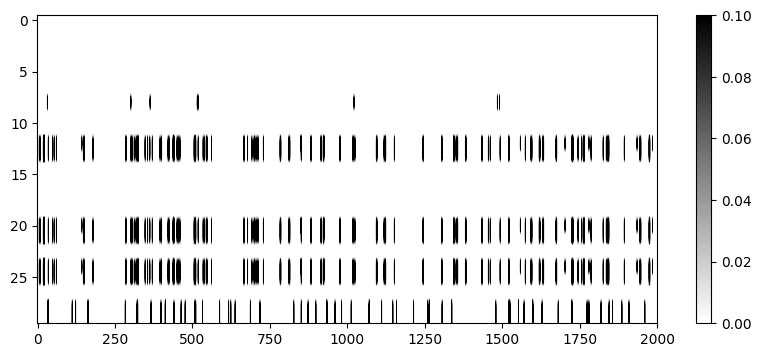

In [62]:
plt.figure(figsize=(10, 4))
plt.imshow(network_dataset.input_spike_dict[11], aspect='auto', cmap='gray_r', vmin=0, vmax=0.1)
plt.colorbar()

In [51]:
np.unique(network_dataset.input_spike_dict[10])

array([0., 1., 2., 4.])

In [37]:
net.cell_types['L5_pyramidal'].sections.keys()

dict_keys(['apical_trunk', 'apical_1', 'apical_2', 'apical_tuft', 'apical_oblique', 'basal_1', 'basal_2', 'basal_3', 'soma'])

In [22]:
network_dataset.neuron_data_dict[0].isec_name_lookup

{'soma_ampa': 0, 'soma_gabaa': 1, 'soma_nmda': 2}

In [12]:
network_dataset.neuron_data_dict[0].isec_array.shape

(3, 20001)

In [ ]:
class CellType_Dataset(torch.utils.data.Dataset):
    #'Characterizes a dataset for PyTorch'
    def __init__(self, sim_data, n_voltages, data_step_size=1, window_size=100, scaler=None, device='cpu'):
        
        self.n_cells, self.n_rec_sites, self.n_times = sim_data.shape
        self.sim_data = [sim_data[idx,:,:].T for idx in range(sim_data.shape[0])]
        
        self.n_voltages = n_voltages
        self.data_step_size = data_step_size
        self.window_size = window_size
        self.device = device
        
        if scaler is None:
            self.scaler = StandardScaler()
            self.scaler.fit(np.vstack(self.sim_data))

        self.sim_data_tensor = self.process_data(self.sim_data)
        
        # X is one step behind y
        self.X_tensor = self.sim_data_tensor[:, :-1, n_voltages:]
        self.y_tensor = self.sim_data_tensor[:, 1:, :n_voltages]
        assert self.X_tensor.shape[0] == self.y_tensor.shape[0]
        self.num_samples = self.X_tensor.shape[0]

        self.X_tensor = self.X_tensor.to(self.device)
        self.y_tensor = self.y_tensor.to(self.device)

    
    def __len__(self):
        #'Denotes the total number of samples'
        return self.num_samples

    def __getitem__(self, slice_index):
        return self.X_tensor[slice_index,:,:], self.y_tensor[slice_index,:,:]
    
    def process_data(self, sim_data):
        unfolded_list = list()
        for idx in range(len(sim_data)):
            sim_data_transformed = self.scaler.transform(sim_data[idx])
            sim_data_transformed = torch.from_numpy(sim_data_transformed)
            sim_data_unfolded = sim_data_transformed.unfold(0, self.window_size + 1, self.data_step_size).transpose(1,2)
            
            unfolded_list.append(sim_data_unfolded)
        sim_data_tensor = torch.concat(unfolded_list)
        return sim_data_tensor
        
        